<a href="https://colab.research.google.com/github/jdwatson08/House_Price_Prediction_Model/blob/main/House_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import chi2_contingency
from sklearn.inspection import permutation_importance
from scipy.stats import norm

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!unzip \*.zip && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [4]:
!ls

 2023-01-07_2015_submission.csv   heart.csv		  sampleSubmission.csv
 all_state			  house_test		  submission.csv
 all_test_v2.csv.zip		  house_train		  test.csv
 all_train.csv.zip		  __MACOSX		  test_features.csv
 Chronic_Kidney_Disease.rar	  model_rf_rs_80	  train.csv
 data_description.txt		  ndtv_data_final.csv	  train_features.csv
 dataset.gsheet			  o2Saturation.csv	  train_labels.csv
 df1_loan.csv			  onehr.data		 'Untitled document.gdoc'
'eqint_tsqp (1).gsheet'		  predictions.csv	  water_potability.csv
 eqint_tsqp.gsheet		  README.docx
 gender_submission.csv		  sample_submission.csv


In [85]:
def wrangle(filename):
  df =pd.read_csv(filename, index_col='Id')

  #Remove columns with majority null values
  threshold = 1000
  null_cols =[]
  for col in df:
    if df[col].isnull().sum() > threshold:
      null_cols.append(col)

  df.drop(columns= null_cols, inplace=True)

  #Remove columns with only 1 value
  one_val =[]
  for col in df:
    if df[col].nunique()==1:
      one_val.append(col)

  df.drop(columns=one_val, inplace=True)

  return df

In [86]:
df = wrangle('house_train')
house_test = wrangle("house_test")

In [87]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,$65.00,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,$80.00,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,$68.00,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,$60.00,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,$84.00,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,$62.00,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1457,20,RL,$85.00,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1458,70,RL,$66.00,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500


In [88]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,"$1,460.00","$1,201.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,452.00","$1,460.00","$1,460.00",...,"$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00","$1,460.00"
mean,$56.90,$70.05,"$10,516.83",$6.10,$5.58,"$1,971.27","$1,984.87",$103.69,$443.64,$46.55,...,$94.24,$46.66,$21.95,$3.41,$15.06,$2.76,$43.49,$6.32,"$2,007.82","$180,921.20"
std,$42.30,$24.28,"$9,981.26",$1.38,$1.11,$30.20,$20.65,$181.07,$456.10,$161.32,...,$125.34,$66.26,$61.12,$29.32,$55.76,$40.18,$496.12,$2.70,$1.33,"$79,442.50"
min,$20.00,$21.00,"$1,300.00",$1.00,$1.00,"$1,872.00","$1,950.00",$0.00,$0.00,$0.00,...,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$1.00,"$2,006.00","$34,900.00"
25%,$20.00,$59.00,"$7,553.50",$5.00,$5.00,"$1,954.00","$1,967.00",$0.00,$0.00,$0.00,...,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$0.00,$5.00,"$2,007.00","$129,975.00"
50%,$50.00,$69.00,"$9,478.50",$6.00,$5.00,"$1,973.00","$1,994.00",$0.00,$383.50,$0.00,...,$0.00,$25.00,$0.00,$0.00,$0.00,$0.00,$0.00,$6.00,"$2,008.00","$163,000.00"
75%,$70.00,$80.00,"$11,601.50",$7.00,$6.00,"$2,000.00","$2,004.00",$166.00,$712.25,$0.00,...,$168.00,$68.00,$0.00,$0.00,$0.00,$0.00,$0.00,$8.00,"$2,009.00","$214,000.00"
max,$190.00,$313.00,"$215,245.00",$10.00,$9.00,"$2,010.00","$2,010.00","$1,600.00","$5,644.00","$1,474.00",...,$857.00,$547.00,$552.00,$508.00,$480.00,$738.00,"$15,500.00",$12.00,"$2,010.00","$755,000.00"


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemodAdd 

<h1>Exploring features with high null values</h1>


In [90]:
df.isnull().sum().sort_values(ascending=False).head(10)

,0
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81
GarageQual,81
GarageCond,81
BsmtExposure,38
BsmtFinType2,38


<h1>Sale Price Visualization</h1>

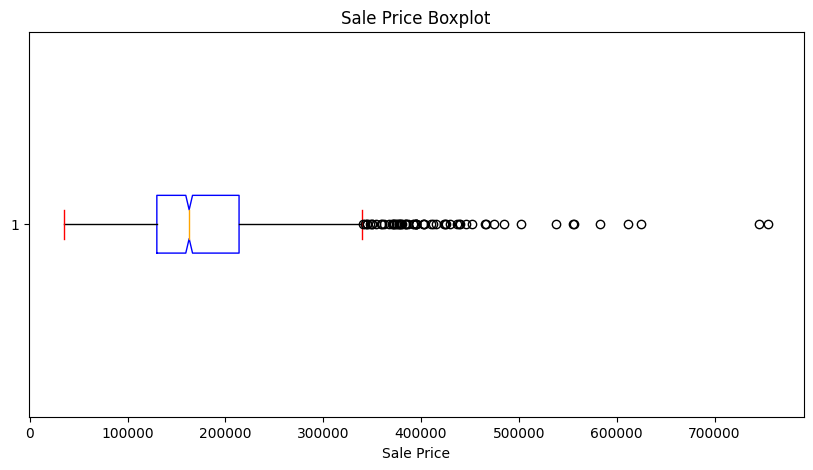

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.boxplot(df['SalePrice'], boxprops=dict(color='blue'), capprops=dict(color='red'), medianprops=dict(color='orange'), notch=True, vert=False, showfliers=True)
plt.title('Sale Price Boxplot')
plt.xlabel('Sale Price')
plt.show()

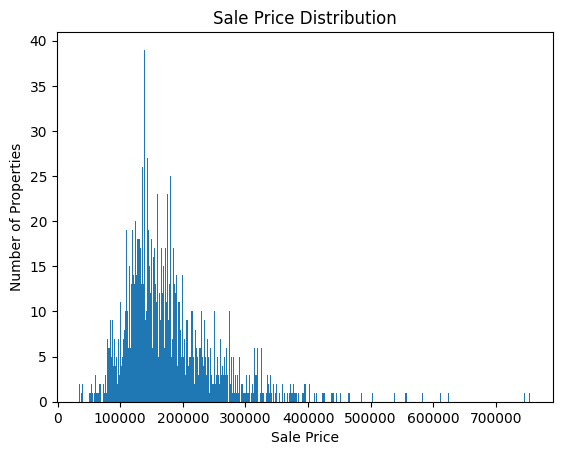

In [92]:
plt.hist(df['SalePrice'], bins=500)
plt.xlabel("Sale Price")
plt.ylabel("Number of Properties")
plt.title("Sale Price Distribution")
plt.show()

<h2>Neighborhood</h2>

In [93]:
df['Neighborhood'].value_counts()

,count
Neighborhood,
NAmes,225
CollgCr,150
OldTown,113
Edwards,100
Somerst,86
Gilbert,79
NridgHt,77
Sawyer,74
NWAmes,73


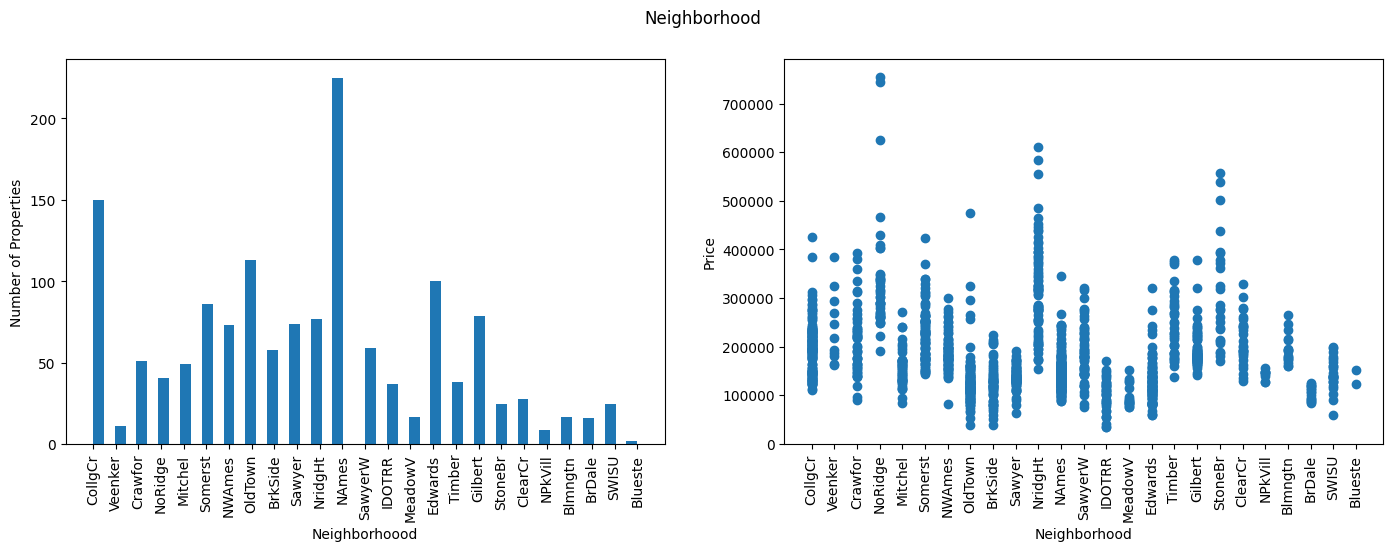

In [94]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,5))
fig.suptitle('Neighborhood')
ax1.hist(df['Neighborhood'], bins = 50)
ax1.set_xlabel("Neighborhoood")
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylabel('Number of Properties')

ax2.scatter(df['Neighborhood'], df['SalePrice'])
ax2.set_xlabel('Neighborhood')
ax2.tick_params(axis='x', labelrotation=90)
ax2.set_ylabel('Price')
plt.show()

<h2>Fire Place Quality</h2>

In [95]:
df['FireplaceQu']

,FireplaceQu
Id,
1,NaN
2,TA
3,TA
4,Gd
5,TA
...,...
1456,TA
1457,TA
1458,Gd


In [96]:
df['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [97]:
df['FireplaceQu'].replace(np.nan, 'None', inplace=True)
df['FireplaceQu'].replace('TA', 'Average', inplace=True)
df['FireplaceQu'].replace('Po', 'Poor', inplace=True)
df['FireplaceQu'].replace('Fa', 'Fair', inplace=True)
df['FireplaceQu'].replace('Ex', 'Excellent', inplace=True)
df['FireplaceQu'].replace('Gd', 'Good', inplace=True)

In [98]:
df['FireplaceQu']

,FireplaceQu
Id,
1,None
2,Average
3,Average
4,Good
5,Average
...,...
1456,Average
1457,Average
1458,Good


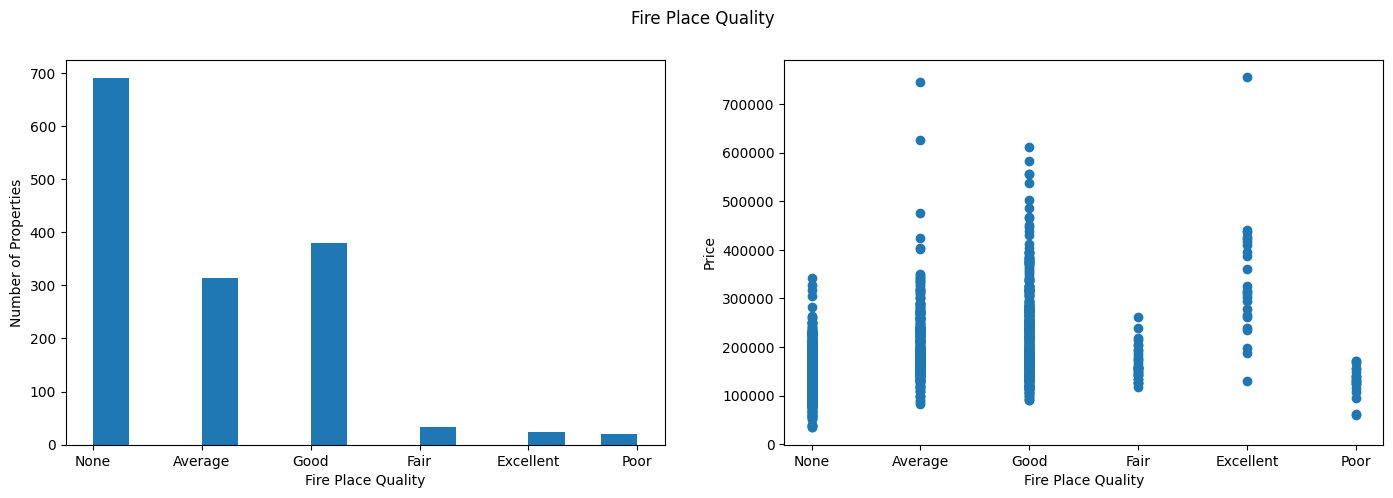

In [99]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,5))
fig.suptitle('Fire Place Quality')
ax1.hist(df['FireplaceQu'], bins = 15)
ax1.set_xlabel("Fire Place Quality")
ax1.set_ylabel('Number of Properties')

ax2.scatter(df['FireplaceQu'], df['SalePrice'])
ax2.set_xlabel('Fire Place Quality')
ax2.set_ylabel('Price')
plt.show()

<h2>Masonry veneer area in square feet</h2>

In [100]:
df['MasVnrArea']

,MasVnrArea
Id,
1,$196.00
2,$0.00
3,$162.00
4,$0.00
5,$350.00
...,...
1456,$0.00
1457,$119.00
1458,$0.00


In [101]:
df['MasVnrArea'].unique()

array([1.960e+02, 0.000e+00, 1.620e+02, 3.500e+02, 1.860e+02, 2.400e+02,
       2.860e+02, 3.060e+02, 2.120e+02, 1.800e+02, 3.800e+02, 2.810e+02,
       6.400e+02, 2.000e+02, 2.460e+02, 1.320e+02, 6.500e+02, 1.010e+02,
       4.120e+02, 2.720e+02, 4.560e+02, 1.031e+03, 1.780e+02, 5.730e+02,
       3.440e+02, 2.870e+02, 1.670e+02, 1.115e+03, 4.000e+01, 1.040e+02,
       5.760e+02, 4.430e+02, 4.680e+02, 6.600e+01, 2.200e+01, 2.840e+02,
       7.600e+01, 2.030e+02, 6.800e+01, 1.830e+02, 4.800e+01, 2.800e+01,
       3.360e+02, 6.000e+02, 7.680e+02, 4.800e+02, 2.200e+02, 1.840e+02,
       1.129e+03, 1.160e+02, 1.350e+02, 2.660e+02, 8.500e+01, 3.090e+02,
       1.360e+02, 2.880e+02, 7.000e+01, 3.200e+02, 5.000e+01, 1.200e+02,
       4.360e+02, 2.520e+02, 8.400e+01, 6.640e+02, 2.260e+02, 3.000e+02,
       6.530e+02, 1.120e+02, 4.910e+02, 2.680e+02, 7.480e+02, 9.800e+01,
       2.750e+02, 1.380e+02, 2.050e+02, 2.620e+02, 1.280e+02, 2.600e+02,
       1.530e+02, 6.400e+01, 3.120e+02, 1.600e+01, 

In [102]:
df['MasVnrArea'].describe()

,MasVnrArea
count,"$1,452.00"
mean,$103.69
std,$181.07
min,$0.00
25%,$0.00
50%,$0.00
75%,$166.00
max,"$1,600.00"


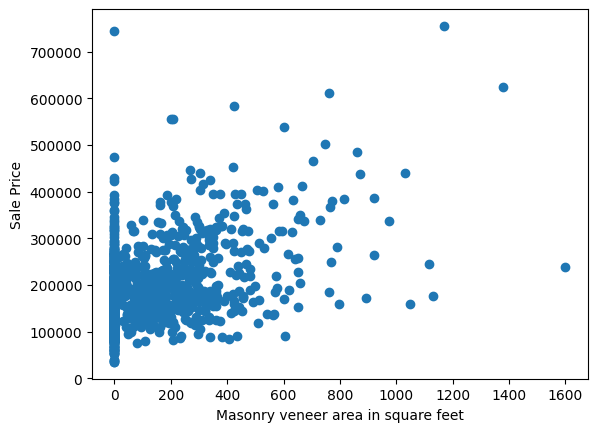

In [103]:
plt.scatter(df['MasVnrArea'], df['SalePrice'])
plt.xlabel('Masonry veneer area in square feet')
plt.ylabel('Sale Price')
plt.show()

<h3>Overall Condition</h3>

In [104]:
df['OverallCond'].unique()

array([5, 8, 6, 7, 4, 2, 3, 9, 1])

In [105]:
df['OverallCond'].value_counts()

,count
OverallCond,
5,821
6,252
7,205
8,72
4,57
3,25
9,22
2,5
1,1


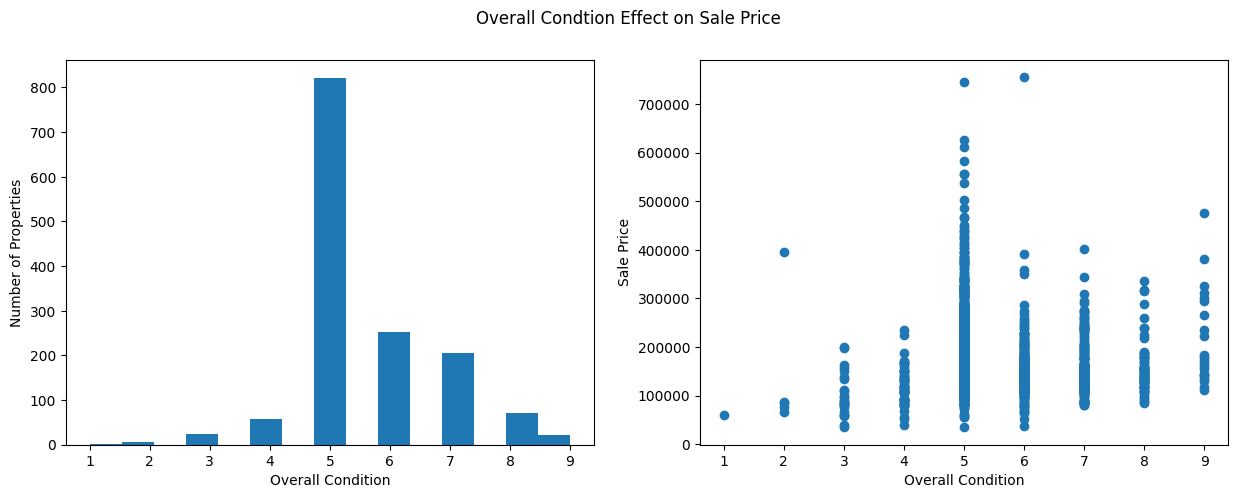

In [106]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Overall Condtion Effect on Sale Price")
ax1.hist(df['OverallCond'], bins = 15)
ax1.set_xlabel('Overall Condition')
ax1.set_ylabel('Number of Properties')
ax2.scatter(df['OverallCond'], df['SalePrice'])
ax2.set_xlabel("Overall Condition")
ax2.set_ylabel('Sale Price')
plt.show()

<h3>Year Built</h3>

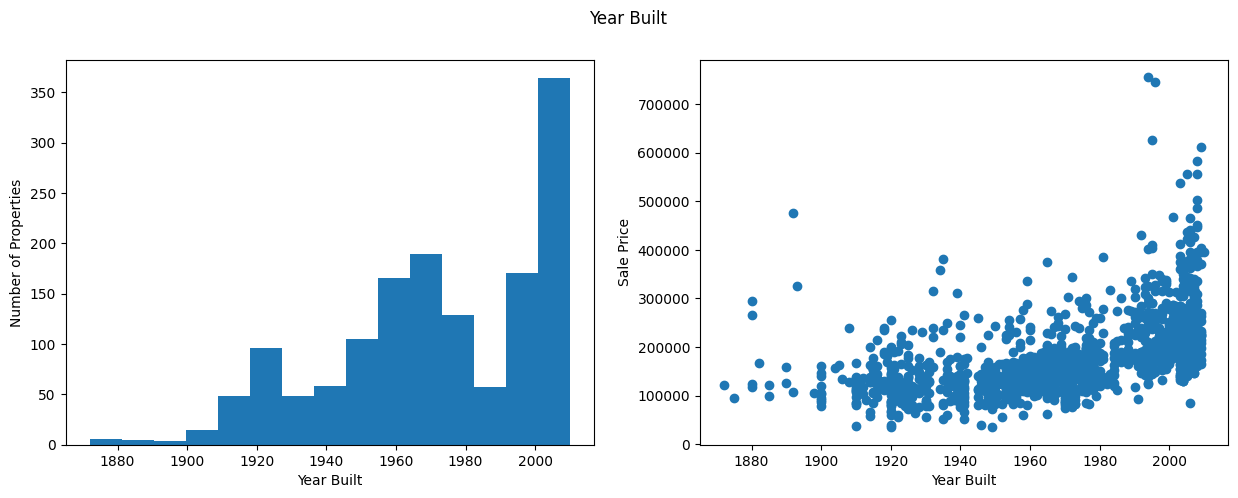

In [107]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Year Built")
ax1.hist(df['YearBuilt'], bins = 15)
ax1.set_xlabel('Year Built')
ax1.set_ylabel('Number of Properties')
ax2.scatter(df['YearBuilt'], df['SalePrice'])
ax2.set_xlabel("Year Built")
ax2.set_ylabel('Sale Price')
plt.show()

<h3>Lot Area</h3>

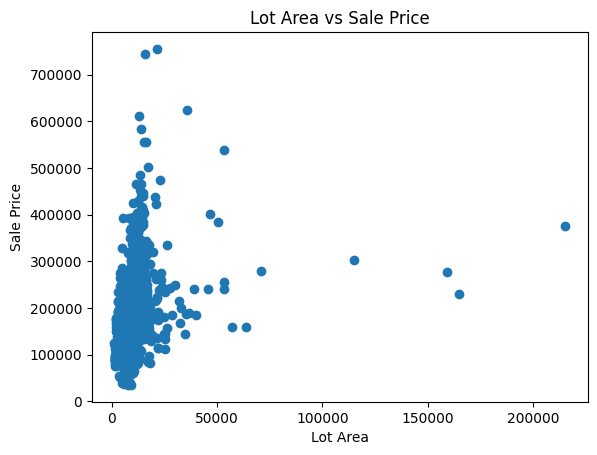

In [108]:
plt.scatter(df['LotArea'],df['SalePrice'])
plt.xlabel("Lot Area")
plt.ylabel("Sale Price")
plt.title("Lot Area vs Sale Price")
plt.show()

<h3>Utilities</h3>

In [109]:
df['Utilities'].value_counts()

,count
Utilities,
AllPub,1459
NoSeWa,1


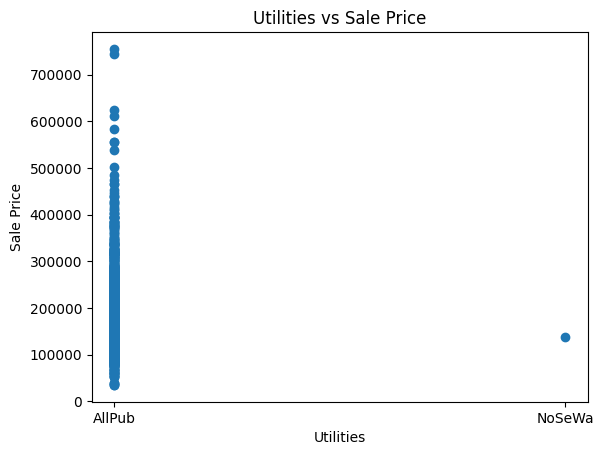

In [110]:
plt.scatter(df['Utilities'], df['SalePrice'])
plt.xlabel("Utilities")
plt.ylabel("Sale Price")
plt.title("Utilities vs Sale Price")
plt.show()

# Define Feature Matrix and Target array

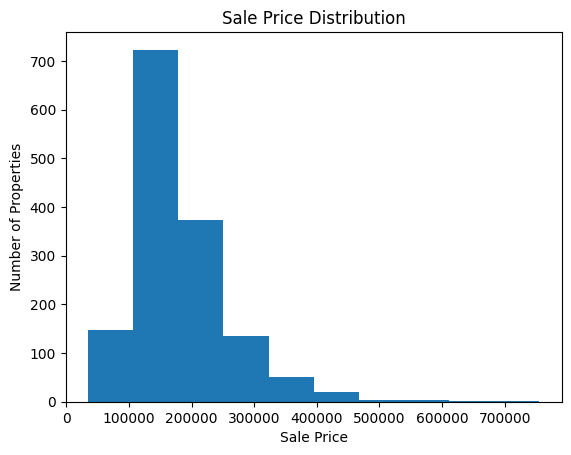

In [111]:
target= 'SalePrice'
X = df.drop(columns=target)
y=df[target]
plt.hist(df['SalePrice'])
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.title('Sale Price Distribution')
plt.show()

In [112]:
log_y = np.log(y)

# Target is Right Skewed

## Test for normal distribution

In [113]:
from scipy import stats

_, p = stats.normaltest(y)
print(p)

2.283848353787728e-133


# Target needs to be transformed with log function

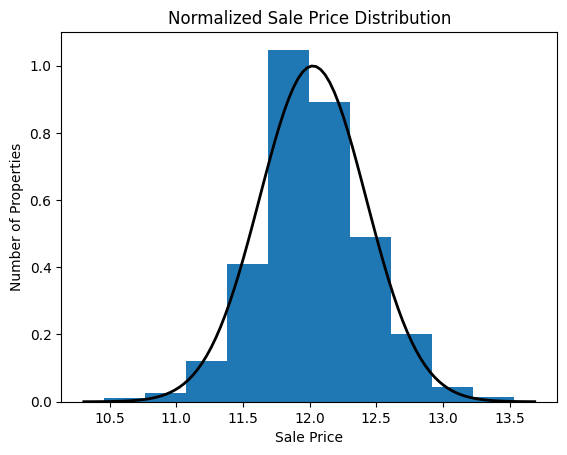

In [114]:
log_sale=np.log(df['SalePrice'])
mu, std = norm.fit(log_sale)

plt.hist(log_sale, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.xlabel("Sale Price")
plt.ylabel("Number of Properties")
plt.title("Normalized Sale Price Distribution")

plt.plot(x, p, 'k', linewidth=2)
plt.show()

## Target is a lot closer to normal distribution now

In [115]:
from scipy import stats

_, p = stats.normaltest(log_y)
print(p)

2.89216582205235e-06


# Baseline

In [116]:
y_log_pred = [y.mean()]*len(y)
baseline_mae = mean_absolute_error(log_y, y_log_pred)
print("The baseline mae:",baseline_mae)

The baseline mae: 180909.17183950983


# Split Data

In [117]:
X_train,X_val,y_train,y_val = train_test_split(X, log_y, test_size=0.1, random_state=42)

# Model

In [118]:
model_lr = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='median'),
    LinearRegression()
)

model_lr.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('linearregression', LinearRegression())])

In [119]:
print("The model score is:",model_lr.score(X_val,y_val))
print("The model mae is:", mean_absolute_error(y_val, model_lr.predict(X_val)))

The model score is: 0.8807673731361425
The model mae is: 0.10959350194782967


# Model 2 is slightly better

In [120]:
model_r = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='median'),
    Ridge()
)

model_r.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('ridge', Ridge())])

In [121]:
print("The model score is:",model_r.score(X_val,y_val))
print("The model mae is:", mean_absolute_error(y_val, model_r.predict(X_val)))

The model score is: 0.8869097045804344
The model mae is: 0.10689408970803986


In [122]:
model_predictions =  model_r.predict(X_val)

## Target Normal validation vs Model's Normal Predictions

In [123]:
log_new_table_list = [pd.DataFrame(model_predictions),pd.DataFrame(y_val)]
new_table_log =  pd.concat(log_new_table_list, axis = 1, join='inner')
new_table_log.rename(columns={0: "Validation Sale Price", "SalePrice": "Model Sale Price Predictions"}, inplace=True)
display(new_table_log)

,Validation Sale Price,Model Sale Price Predictions
16,$12.11,$11.79
30,$11.89,$11.13
44,$11.74,$11.78
45,$11.77,$11.86
50,$11.74,$11.75
52,$11.69,$11.65
60,$11.20,$11.74
66,$11.65,$12.67
68,$11.68,$12.33
71,$11.78,$12.40


## Target True Validation vs Model True Prediction

In [124]:
pd.options.display.float_format = '${:,.2f}'.format
new_table_list = [pd.DataFrame(np.exp(model_predictions)),pd.DataFrame(np.exp(y_val))]
new_table =  pd.concat(new_table_list, axis = 1, join='inner')
new_table.rename(columns={0: "Validation Sale Price", "SalePrice": "Model Sale Price Predictions"}, inplace=True)
display(new_table)

,Validation Sale Price,Model Sale Price Predictions
16,"$181,448.30","$132,000.00"
30,"$145,956.49","$68,500.00"
44,"$125,823.57","$130,250.00"
45,"$129,620.49","$141,000.00"
50,"$126,101.00","$127,000.00"
52,"$119,670.94","$114,500.00"
60,"$72,955.14","$124,900.00"
66,"$114,486.43","$317,000.00"
68,"$117,661.12","$226,000.00"
71,"$130,848.57","$244,000.00"


# Model Predictions vs Validation Data Visualization



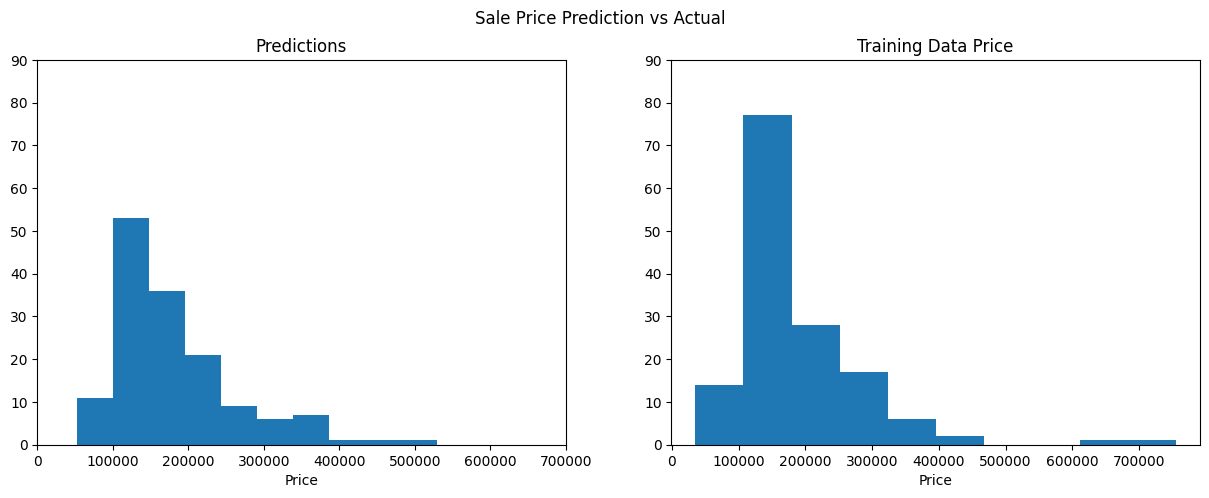

In [125]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Sale Price Prediction vs Actual")
ax1.hist(np.exp(pd.DataFrame(model_predictions)))
ax1.set_xlabel("Price")
ax1.set_yticks(np.arange(0, 100, 10))
ax1.set_xticks(np.arange(0,800000,100000))
ax1.set_title("Predictions")

ax2.hist(np.exp(y_val))
ax2.set_xlabel("Price")
ax2.set_yticks(np.arange(0, 100, 10))
ax2.set_xticks(np.arange(0,800000,100000))
ax2.set_title("Training Data Price")
plt.show()

# Predictions for Kaggle test file

In [126]:
house_test['Utilities'] ='AllPub'

In [127]:
house_test = house_test[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']]

## Predict values and inverse log to get true values

In [128]:
predictions = pd.DataFrame(np.exp(model_r.predict(house_test)))

In [129]:
predictions.rename(columns={0:"SalePrice"},inplace=True)
predictions = predictions['SalePrice'].astype('int')

In [130]:
predictions = pd.DataFrame(predictions)

In [131]:
predictions.to_csv("predictions.csv", index = False)
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Kaggle contest predictions

In [132]:
predictions

,SalePrice
0,127342
1,149491
2,179596
3,196274
4,203701
...,...
1454,82281
1455,79049
1456,160193
1457,117435
